In [0]:
# !pip install mpl_finance # install in colab

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_finance import candlestick2_ochl


class Signal_Visualization(object):
    def __init__(self, data, details):
        self.data = data
        self.details = details
        self.Reset()
        
    def Reset(self):
        self.idx_buy = []
        self.idx_sell = []
        self.idx_close = []
        self.idx_stoploss = []
        self.price_buy = []        
        self.price_sell = []        
        self.price_close = []        
        self.price_stoploss = []
    
    def Convert(self, df, interval, unit):
        period = '{i}{u}'.format(i = interval, u = unit)
        df = df.resample(period).agg({'Open':'first', 
                                      'High':'max', 
                                      'Low':'min',
                                      'Close':'last',
                                      'Volume':'sum'}).dropna(axis=0)
        df.reindex(pd.to_datetime(df.index.strftime('%F %T')))
        df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

        return df
    
    
    def Add_Point(self, date, price, flag = 'long'):
        for i, d in enumerate(date):
            if flag == 'long':
                color = 'red'
                marker = '^'
            elif flag == 'short':
                color = 'blue'
                marker = 'v'
            elif flag == 'stoploss':
                color = 'green'
                marker = 'x'

            plt.plot(d, price[i], marker = marker, markersize = 15, color = color)


    def Change_Period(self, t, interval, unit):
        period = '{i}{u}'.format(i = interval, u = unit)

        _time = pd.to_datetime(t)
        df = pd.DataFrame({'Time':_time, 'Price':[0]}).set_index('Time')
        _time = df.resample(period, closed = 'right', label = 'right').agg({'Price':'first'}).index[0]

        return _time


    def Get_Signal_Index(self, data):
        for idx, detail in self.details.iterrows():
            open_time = Change_Period(t = detail.open_time, interval = 15, unit = 'Min')
            close_time = Change_Period(t = detail.close_time, interval = 15, unit = 'Min')
            open_idx = data[data['Time'] == open_time]
            close_idx = data[data['Time'] == close_time]

            if not open_idx.empty:
                if detail.side == 'buy':
                    self.idx_buy.append(open_idx.index.tolist()[0])
                    self.price_buy.append(detail.open_price)
                elif detail.side == 'sell':
                    self.idx_sell.append(open_idx.index.tolist()[0])
                    self.price_sell.append(detail.open_price)

            if not close_idx.empty:
                self.idx_close.append(close_idx.index.tolist()[0])
                self.price_close.append(detail.close_price)


    def Select_Stoploss(self):
        for i, v in enumerate(self.idx_close):
            if v not in self.idx_buy + self.idx_sell:
                self.idx_stoploss.append(v)
                self.price_stoploss.append(self.price_close[i])

    
    def Plot_Candlestick(self, data, title = ''):
        data.columns = data.columns.str.upper()
        if all(name in data.columns.tolist() for name in ['TIME', 'OPEN', 'HIGH', 'LOW', 'CLOSE']):
            fig = plt.figure(figsize = (16, 8))
            x_interval = int(len(data)/5)
            gs = gridspec.GridSpec(3,1)
            # self.k_ax = self.fig.add_subplot(gs[0:2])
            k_ax = fig.add_subplot(gs[0:3])
            k_ax.set_xticks(range(0, len(data['TIME']), x_interval))
            k_ax.set_xticklabels(data['TIME'][::x_interval])
            k_ax.ticklabel_format(useOffset=False, style='plain', axis='y')
            plt.title(title)
            plt.ylabel('Price')
            plt.xlabel('Time')
            candlestick2_ochl(k_ax,
                              data['OPEN'].values,
                              data['CLOSE'].values,
                              data['HIGH'].values,
                              data['LOW'].values,
                              width = 0.6,
                              colorup = 'r',
                              colordown = 'green',
                              alpha = 0.4)
            data['MA10'] = data['CLOSE'].rolling(center = False, window = 10).mean()
            Add_Point(self.idx_buy, self.price_buy, 'long')
            Add_Point(self.idx_sell, self.price_sell, 'short')
            Add_Point(self.idx_stoploss, self.price_stoploss, 'stoploss')
            plt.plot(data.MA10)
        else:
            print('Column(Date, OPEN, HIGH, LOW or CLOSE) is missing!')
    
    



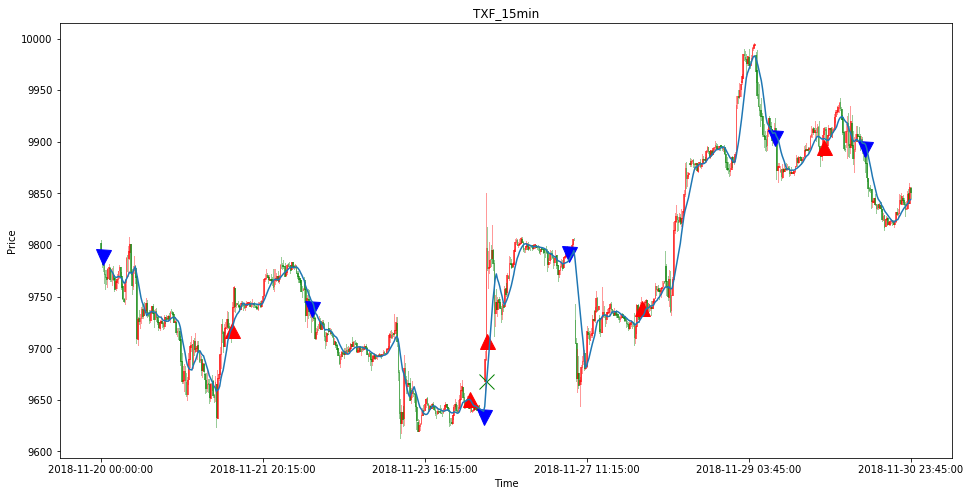

In [48]:
data = pd.read_csv('TXF_1min.csv').drop(columns = 'Unnamed: 0')
data.Time = pd.to_datetime(data.Time)
data = data.set_index('Time')
details = pd.read_csv('detail.csv')

sv = Signal_Visualization(data, details)

min_15 = sv.Convert(df = data, interval = 15, unit = 'MIN')
plot_data = min_15['2018-11-20':'2018-11-30']
plot_data = plot_data.reset_index()

sv.Get_Signal_Index(plot_data)
sv.Select_Stoploss()
sv.Plot_Candlestick(plot_data, 'TXF_15min')

plt.show()


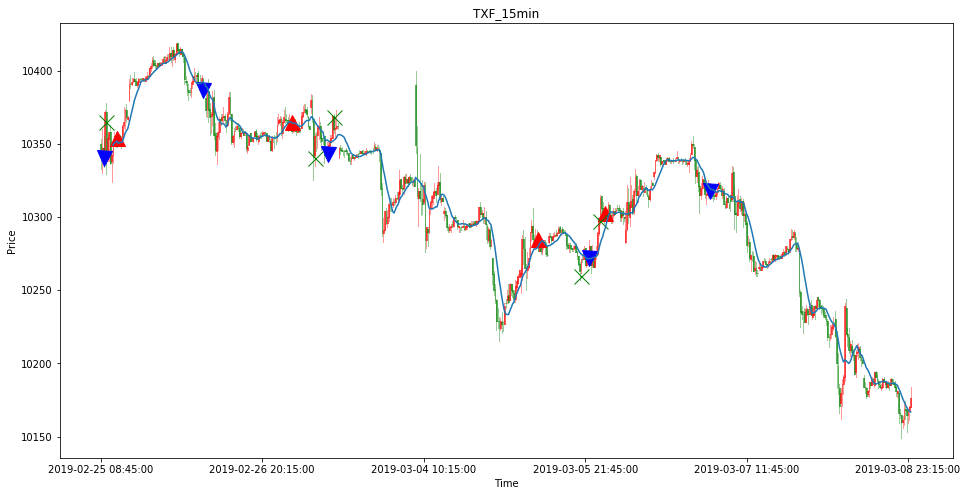

In [49]:
plot_data = min_15['2019-02-25':'2019-03-08']
plot_data = plot_data.reset_index()

sv.Reset()
sv.Get_Signal_Index(plot_data)
sv.Select_Stoploss()
sv.Plot_Candlestick(plot_data, 'TXF_15min')

plt.show()